In [1]:
import pandas as pd
import sqlite3

In [3]:
def pdquery(db, sql, params=()):
    with sqlite3.connect(db) as con:
        res = pd.read_sql_query(sql, con, params = params)
    return res

def query(db, sql, params=()):
    with sqlite3.connect(db) as con:
        res = con.execute(sql,params)
    return res.fetchall()

In [4]:
ndt_db = 'NDT/ndt_sql.db'

In [5]:
df = pdquery(ndt_db, """
    select 
        a.sent_id, 
        a.token_order as dep_id, 
        b.token_order as head_id, 
        a.form as dep_form,  
        a.deprel, 
        b.form as head_form,
        a.lemma as lemma_dep, 
        b.lemma as lemma_head
    from 
        ndt as a, 
        ndt as b 
    where 
        a.deprel = 'KOORD'  
        and a.head = b.token_order 
        and a.sent_id = b.sent_id 
    """)

In [13]:
pdquery(ndt_db, "select * from sqlite_master").style

,type,name,tbl_name,rootpage,sql
0,table,ndt,ndt,2,"CREATE TABLE ""ndt"" ( ""index"" INTEGER, ""token_id"" INTEGER, ""token_order"" INTEGER, ""form"" TEXT, ""lemma"" TEXT, ""pos"" TEXT, ""feats"" TEXT, ""head"" INTEGER, ""deprel"" TEXT, ""sent_id"" INTEGER, ""ud_id"" INTEGER, ""language_code"" TEXT, ""data_split"" TEXT, ""newpar"" INTEGER, ""document_id"" REAL )"
1,index,ix_ndt_index,ndt,3,"CREATE INDEX ""ix_ndt_index""ON ""ndt"" (""index"")"
2,index,_fs_,ndt,12527,"CREATE INDEX _fs_ on ndt (form, sent_id)"
3,index,_ls_,ndt,15042,"CREATE INDEX _ls_ on ndt (lemma, sent_id)"


In [6]:
df['diff'] = df.dep_id - df.head_id

In [14]:
df['diff'].describe()

count    22963.000000
mean         6.041066
std          5.476702
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         76.000000
Name: diff, dtype: float64

In [15]:
ls = pd.DataFrame([(i,len(df[abs(df['diff']) == i])) for i in range(2,20)], columns=['len','antall']).set_index('len')

<AxesSubplot: title={'center': 'Antall dependenser med lengde'}, xlabel='len'>

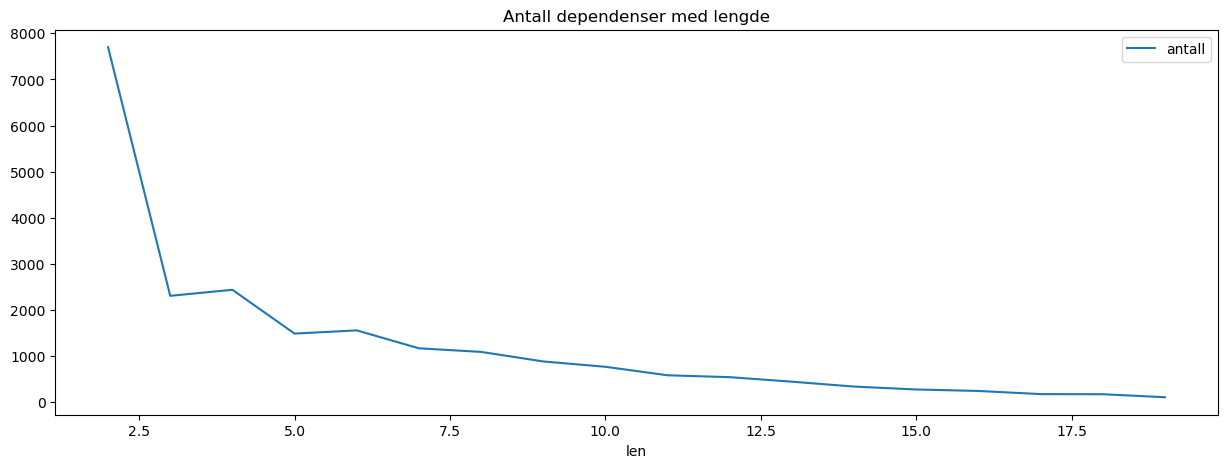

In [16]:
ls.plot(title="Antall dependenser med lengde", figsize=(15,5))

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

def make_sentence_graph(indx):
    edges = ndt[ndt.sent_id == indx]["token_order head deprel".split()]
    nodes = ndt[ndt.sent_id == indx]["token_order form".split()]

    #edgelist = [(int(e[1].token_order), int(e[1]['head']), {'name':e[1].deprel}) for e in edges.iterrows()]
    edgelist = [(int(e[1]['head']), int(e[1].token_order), {'name':e[1].deprel}) for e in edges.iterrows()]
    nodelist = [(int(e[1].token_order), {'name':e[1]['form']}) for e in nodes.iterrows()] 

    G = nx.DiGraph()
    
    G.add_edges_from(edgelist)
    G.add_nodes_from(nodelist)
    
    # add name for root element
    G.nodes[0]['name'] = 'root'
   
    return G

def draw_graph(G):
    edgelabels = {(x[0], x[1]):x[2]['name'] for x in G.edges(data=True)}
    nodelabels = {x[0]:x[1]['name'] for x in G.nodes(data=True)}
    pos =  nx.nx_agraph.graphviz_layout(G, prog="dot")
    G.graph.setdefault('graph', {})['rankdir'] = 'BT'
    n = nx.dag_longest_path(G)
    fig = plt.figure(figsize=(16,1.4*len(n)))
    # nodes
    options = {"edgecolors": "tab:gray", "node_size": 0, "alpha": 0.9}
    nx.draw_networkx_edges(G, pos, width=1.2, alpha=0.3, arrows=True, edge_color='gray') #, connectionstyle="arc3,rad=0.3");
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edgelabels, font_size=8,font_color='orange');
    nx.draw_networkx_labels(G, pos, labels = nodelabels, font_color='darkblue', font_size=12);
    #st.pyplot(fig)

In [19]:
ndt = pdquery(ndt_db, "select * from ndt")

In [25]:
df.sort_values(by='diff')

,sent_id,dep_id,head_id,dep_form,deprel,head_form,lemma_dep,lemma_head,diff
8071,13672,39,38,Bakken,KOORD,Karl-Johan,Bakken,Karl-Johan,1
20206,33082,12,11,kan,KOORD,må,kunne,måtte,1
3285,5264,2,1,mas,KOORD,Mas,mas,mas,1
3294,5272,2,1,piiip,KOORD,Piiip,piiip,piiip,1
3092,4946,10,9,etter,KOORD,fredag,etter,fredag,1
...,...,...,...,...,...,...,...,...,...
15042,24880,67,4,prellar,KOORD,ser,prelle,sjå,63
4648,7822,71,7,Gro,KOORD,Cathrine,Gro,Cathrine,64
4649,7822,78,5,legejournaler,KOORD,intervjuer,legejournal,intervju,73
17870,30129,94,20,er,KOORD,er,vere,vere,74


In [26]:
G = make_sentence_graph(24836)

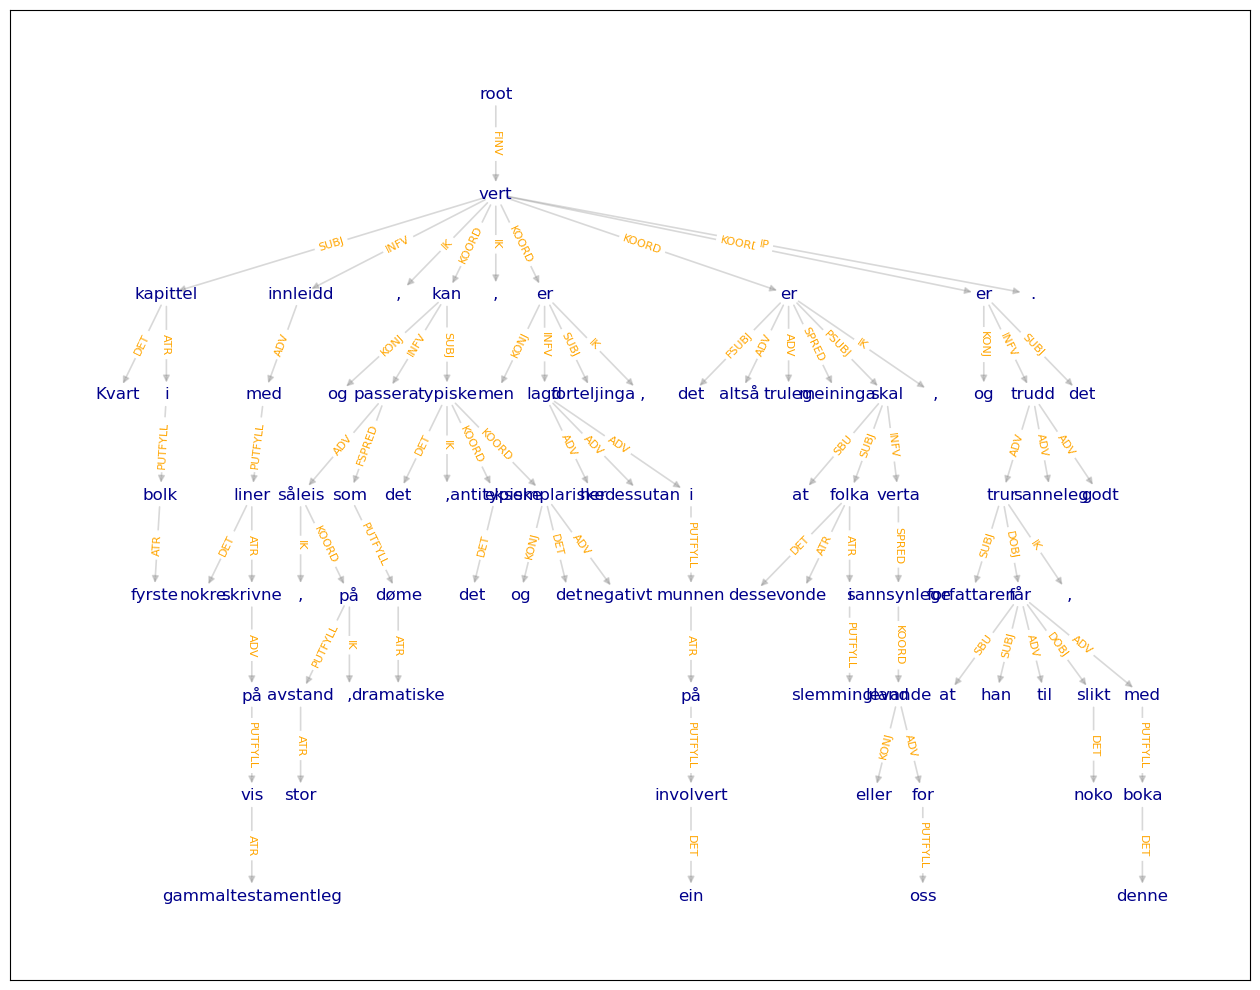

In [27]:
draw_graph(G)

In [95]:
df['diff'].describe()

count    22963.000000
mean         6.041066
std          5.476702
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         76.000000
Name: diff, dtype: float64

In [86]:
def make_sentence(identifier):
    return ' '.join([x[0] for x in query(ndt_db, "select form from ndt where sent_id = ? order by rowid", (identifier,))])

In [87]:
make_sentence(5)

'Deretter fulgte " Turbot au Four - purée de chou-fleur " .'

In [4]:
ndt = pd.read_csv("NDT/ndt_all_reduce.csv", index_col = 0)

In [25]:
for i,x in enumerate(ndt[ndt["deprel"] == 'KOORD'][[
    'token_id', 'sent_id', 'head', 'form', 'lemma'
]].iterrows()):
    
    if i > 10:
        break
    
    print(ndt[(ndt.sent_id == x[1]['sent_id']) & (ndt.token_id == x[1]['head'])])

   token_id  token_order form lemma    pos               feats  head deprel  \
0         1            1  Lam   lam  subst  appell|nøyt|ub|ent     0   FRAG   

   sent_id  ud_id language_code data_split  newpar  document_id  
0        1      1         nb-NO      train       0          NaN  
Empty DataFrame
Columns: [token_id, token_order, form, lemma, pos, feats, head, deprel, sent_id, ud_id, language_code, data_split, newpar, document_id]
Index: []
Empty DataFrame
Columns: [token_id, token_order, form, lemma, pos, feats, head, deprel, sent_id, ud_id, language_code, data_split, newpar, document_id]
Index: []
Empty DataFrame
Columns: [token_id, token_order, form, lemma, pos, feats, head, deprel, sent_id, ud_id, language_code, data_split, newpar, document_id]
Index: []
Empty DataFrame
Columns: [token_id, token_order, form, lemma, pos, feats, head, deprel, sent_id, ud_id, language_code, data_split, newpar, document_id]
Index: []
Empty DataFrame
Columns: [token_id, token_order, form, lemma,